<a href="https://colab.research.google.com/github/vksyr/IST718/blob/master/project_Maya_Mileva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Project 

## ELUTIONS

In [ ]:
## Load the packages
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy.stats
import pylab

from pandas import Series
from statistics import mean
from statistics import median

import itertools
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 300)

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import plotly.graph_objects as go

import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification

from fbprophet import Prophet
from matplotlib import pyplot

from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults


!pip install pmdarima
import pmdarima as pm
from pmdarima.arima import auto_arima

pd.plotting.register_matplotlib_converters() 

from IPython.display import display
from dateutil.parser import parse 

In [3]:
df = pd.read_csv('/content/dataset_for_technical_assessment.csv', parse_dates=['Description'])

VK - View TS Plot

In [4]:
df.footer()

AttributeError: ignored

In [5]:
df

,Description,y1,y2,x1,x2,x3,x4,x5,x6,x7,x8
0,2016-01-01 00:00:00,0.008133,0.805288,0.934119,0.182838,0.282637,0.612302,0.218844,0.036615,0.695623,0.286383
1,2016-01-01 00:05:00,0.008964,0.799772,0.934014,0.180689,0.281720,0.611908,0.220869,0.037616,0.693026,0.296014
2,2016-01-01 00:10:00,0.008906,0.809219,0.934031,0.181439,0.282202,0.610927,0.222187,0.034264,0.692654,0.289457
3,2016-01-01 00:15:00,0.008469,0.804602,0.934367,0.182620,0.282305,0.612801,0.221935,0.034894,0.693397,0.290959
4,2016-01-01 00:20:00,0.006882,0.799026,0.934884,0.180871,0.281051,0.610566,0.218883,0.038596,0.690928,0.287653
...,...,...,...,...,...,...,...,...,...,...,...
157807,2017-07-01 23:35:00,0.007516,0.725023,0.948420,0.627338,0.632173,0.631040,0.261269,0.042838,0.683385,0.231942
157808,2017-07-01 23:40:00,0.007683,0.722261,0.949335,0.633572,0.639500,0.628861,0.260363,0.046228,0.683139,0.227148
157809,2017-07-01 23:45:00,0.008906,0.728316,0.948450,0.639345,0.645229,0.632574,0.262826,0.043451,0.690426,0.236186
157810,2017-07-01 23:50:00,0.009094,0.733958,0.946910,0.640376,0.646174,0.634153,0.269820,0.045295,0.693872,0.242765


In [126]:
df['Date'] = pd.to_datetime(df['Description'], format='%Y-%m-%d %h:%m%s', errors='coerce')
df = df.set_index('Date')

In [ ]:
df.head()

VK: Find anomolies

Source: https://towardsdatascience.com/time-series-of-price-anomaly-detection-13586cd5ff46

WIth only **Y1**

In [ ]:
# 1. Find elbow
data = df[['y1','x1','x2','x3','x4','x5','x6','x7','x8']]
data = data.fillna(method='bfill')
n_cluster = range(1, 5)
from sklearn.cluster import KMeans
#import sklearn.cluster.KMeans
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

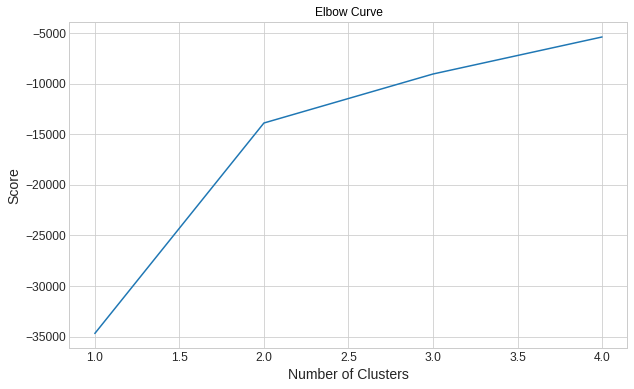

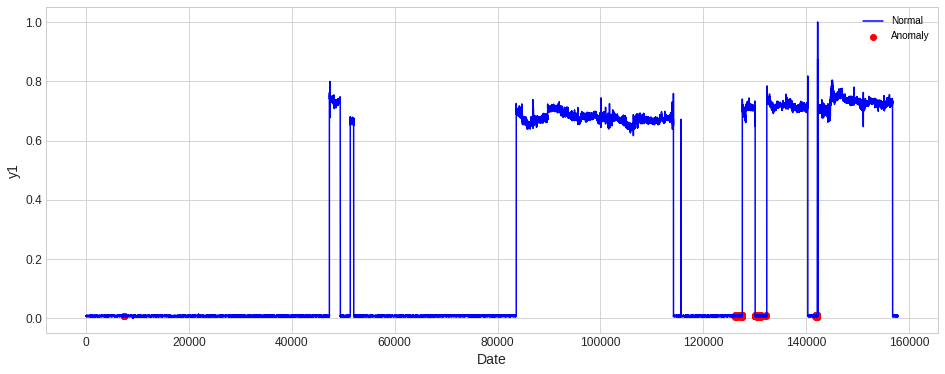

In [6]:
# 1. Find elbow
data = df[['y1','x1','x2','x3','x4','x5','x6','x7','x8']]
data = data.fillna(method='bfill')
n_cluster = range(1, 5)
from sklearn.cluster import KMeans
#import sklearn.cluster.KMeans
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

# Elbow at 2 clusters

# 2. Find anomalies, and label them in df
import numpy as np
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.iloc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[2])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = np.array((distance >= threshold).astype(int))

# 3. View anomalies in TS View
fig, ax = plt.subplots(figsize=(16,6))
a = df.loc[df['anomaly1'] == 1, ['y1']] #anomaly
ax.plot(df.index, df['y1'], color='blue', label='Normal')
ax.scatter(a.index, a['y1'], color='red', label='Anomaly')
plt.xlabel('Date')
plt.ylabel('y1')
plt.legend()
plt.show();

WIth only **Y2**

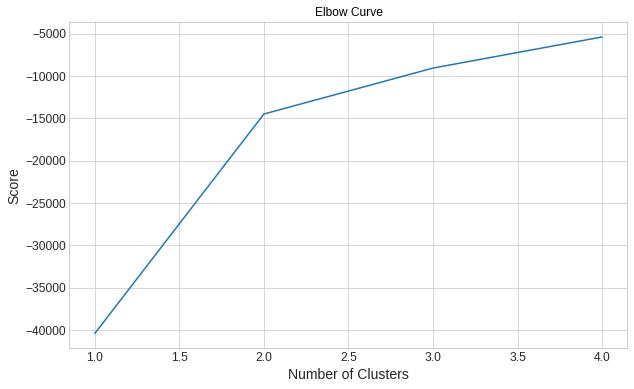

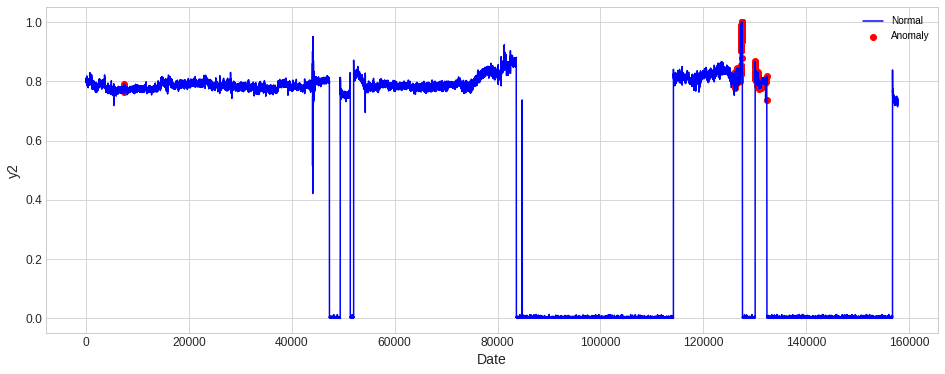

In [8]:
# 1. Find elbow
data = df[['y2','x1','x2','x3','x4','x5','x6','x7','x8']]
data = data.fillna(method='bfill')
n_cluster = range(1, 5)
from sklearn.cluster import KMeans
#import sklearn.cluster.KMeans
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

# Elbow at 2 clusters

# 2. Find anomalies, and label them in df
import numpy as np
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.iloc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[2])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly2'] = np.array((distance >= threshold).astype(int))

# 3. View anomalies in TS View
fig, ax = plt.subplots(figsize=(16,6))
a = df.loc[df['anomaly2'] == 1, ['y2']] #anomaly
ax.plot(df.index, df['y2'], color='blue', label='Normal')
ax.scatter(a.index, a['y2'], color='red', label='Anomaly')
plt.xlabel('Date')
plt.ylabel('y2')
plt.legend()
plt.show();